In [1]:
#load necessary packages 
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#set seed for the analysis to be reproducible
set.seed(1)

In [3]:
#load data into R
#use head() since data is too large
data_set<- read_delim("https://zenodo.org/record/5777340/files/dataset.csv?download=1", delim = ";")
my_data <- data_set |> 
    select(`Gender`, `Age at enrollment`, `Curricular units 1st sem (grade)`, 
           `Curricular units 2nd sem (grade)`, `Target`) |>
    filter(Target != "Enrolled") |> # filter out "Enrolled"
    mutate(Target = factor(Target, levels = c("Dropout", "Graduate")))
           # Gender = factor(Gender, levels = c("0", "1")) |>
           # recode("0" = "Female", "1" = "Male"))
colnames(my_data) <- c('gender', 'enrollment_age', 'first_semester_grade', 'second_semester_grade', 'status') # rename

head(my_data) #take a look at data

Rows: 4424 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (34): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,enrollment_age,first_semester_grade,second_semester_grade,status
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,20,0.00000,0.00000,Dropout
1,19,14.00000,13.66667,Graduate
1,19,0.00000,0.00000,Dropout
0,20,13.42857,12.40000,Graduate
0,45,12.33333,13.00000,Graduate
1,50,11.85714,11.50000,Graduate


In [4]:
# split data, create training data and testing data
data_split <- initial_split(my_data, prop = 0.2, strata = status)
data_train <- training(data_split)   
data_test <- testing(data_split)

In [5]:
# produce a summary table, grouped by target
summary_table <- data_train |>
    group_by(status) |>
    summarize(status_count = n(),
              female_count = sum(gender == 0),
              male_count = sum(gender == 1),
              mean_enrollment_age = mean(enrollment_age, na.rm = TRUE),
              mean_first_semester_grade = mean(first_semester_grade, na.rm = TRUE),
              mean_second_semester_grade = mean(second_semester_grade, na.rm = TRUE),
              missing_data = sum(is.na(enrollment_age), is.na(first_semester_grade), is.na(second_semester_grade)))
summary_table

status,status_count,female_count,male_count,mean_enrollment_age,mean_first_semester_grade,mean_second_semester_grade,missing_data
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
Dropout,284,150,134,26.46127,7.286633,5.871582,0
Graduate,441,328,113,21.85488,12.441531,12.448759,0


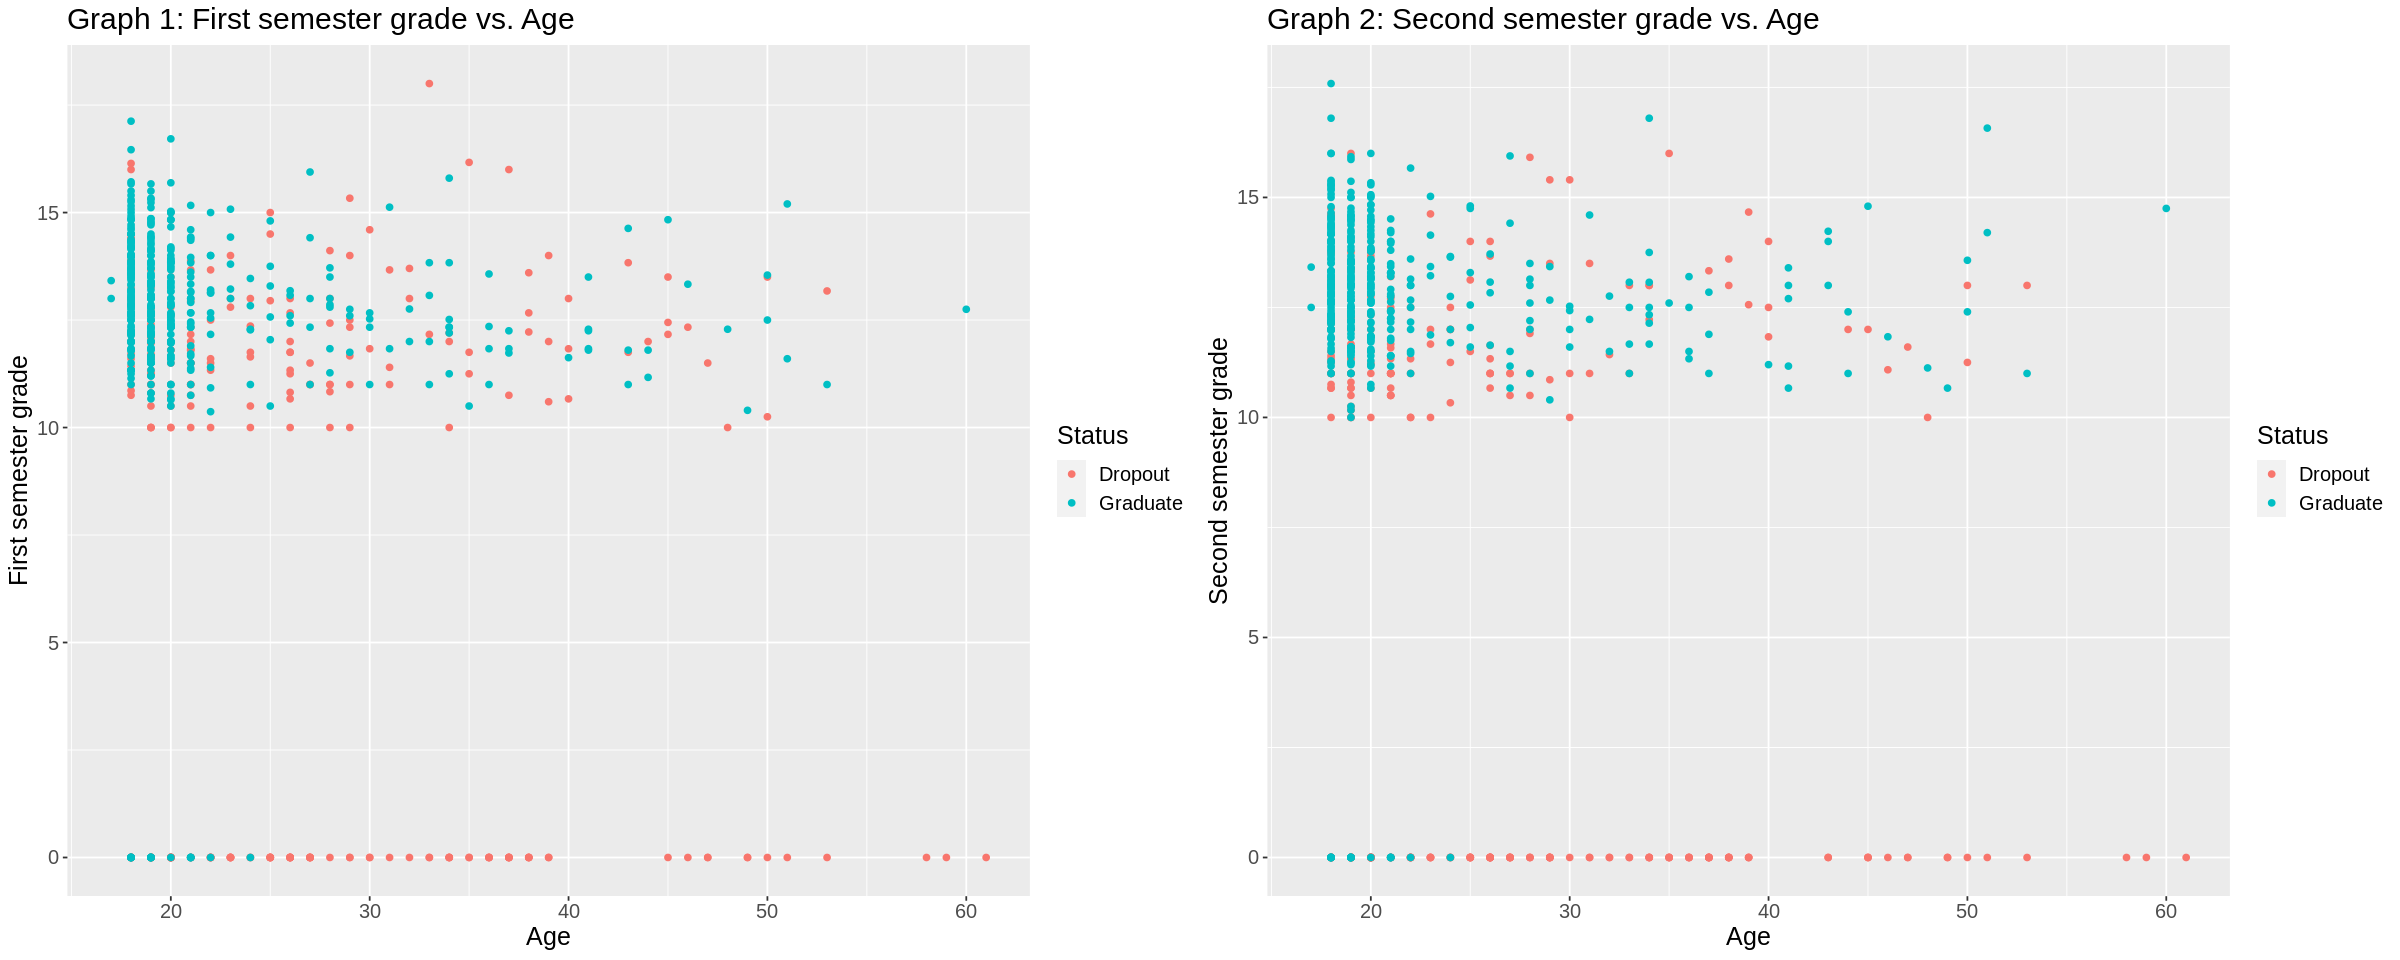

In [6]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot_one <- ggplot(data_train,
                   aes(x = enrollment_age, y = first_semester_grade, colour = status)) +
                           geom_point() +
                           labs(x = "Age", y = "First semester grade", title = "Graph 1: First semester grade vs. Age",
                                colour = "Status") +
                           theme(text = element_text(size = 15))
plot_two <- ggplot(data_train,
                   aes(x = enrollment_age, y = second_semester_grade, colour = status)) +
                           geom_point() + 
                           labs(x = "Age", y = "Second semester grade", title = "Graph 2: Second semester grade vs. Age",
                                colour = "Status") +
                           theme(text = element_text(size = 15))
plot_grid(plot_one, plot_two)

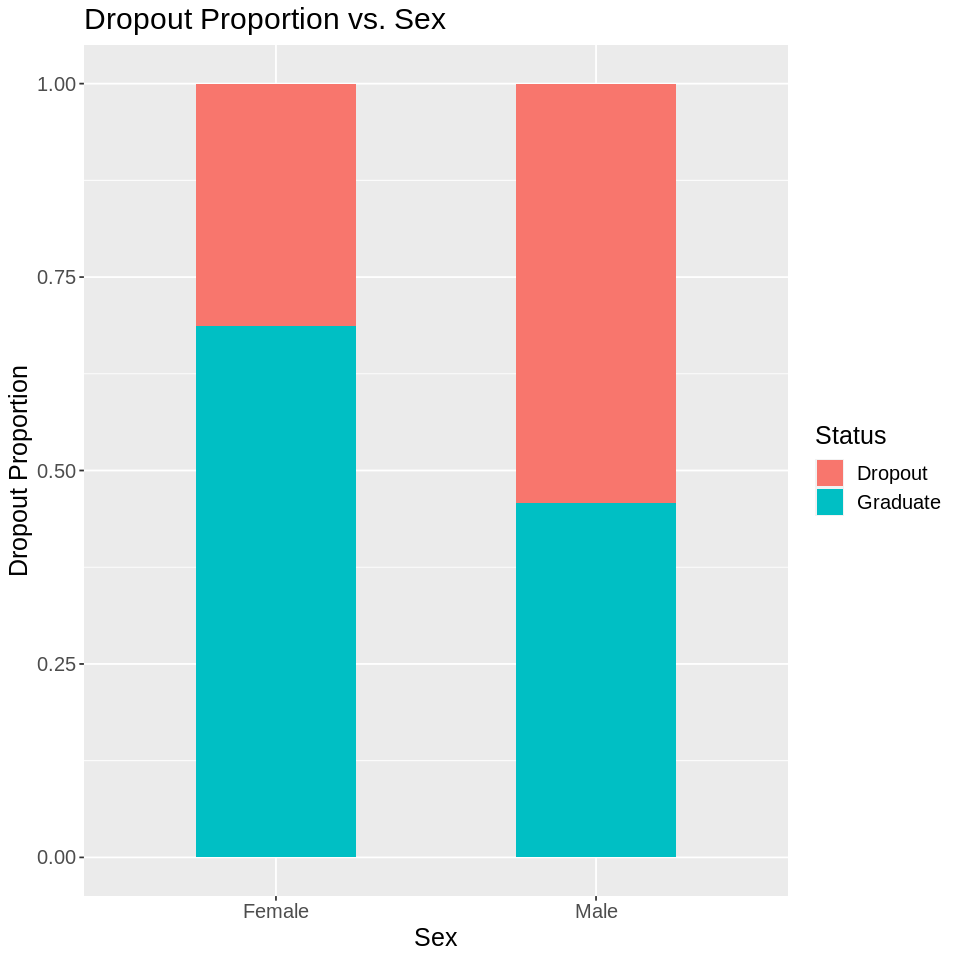

In [7]:
options(repr.plot.width = 8, repr.plot.height = 8)
proportion_bar_plot <- data_train |>
   mutate(gender = factor(gender, levels = c("0", "1"), labels = c("Female", "Male"))) |>
   ggplot(aes(x = gender, fill = status)) + 
   geom_bar(position = 'fill', width = 0.5) + 
   xlab("Sex") +
   ylab("Dropout Proportion") +
   labs(fill = "Status") +
   ggtitle("Dropout Proportion vs. Sex") +
   theme(text = element_text(size = 15))         
proportion_bar_plot

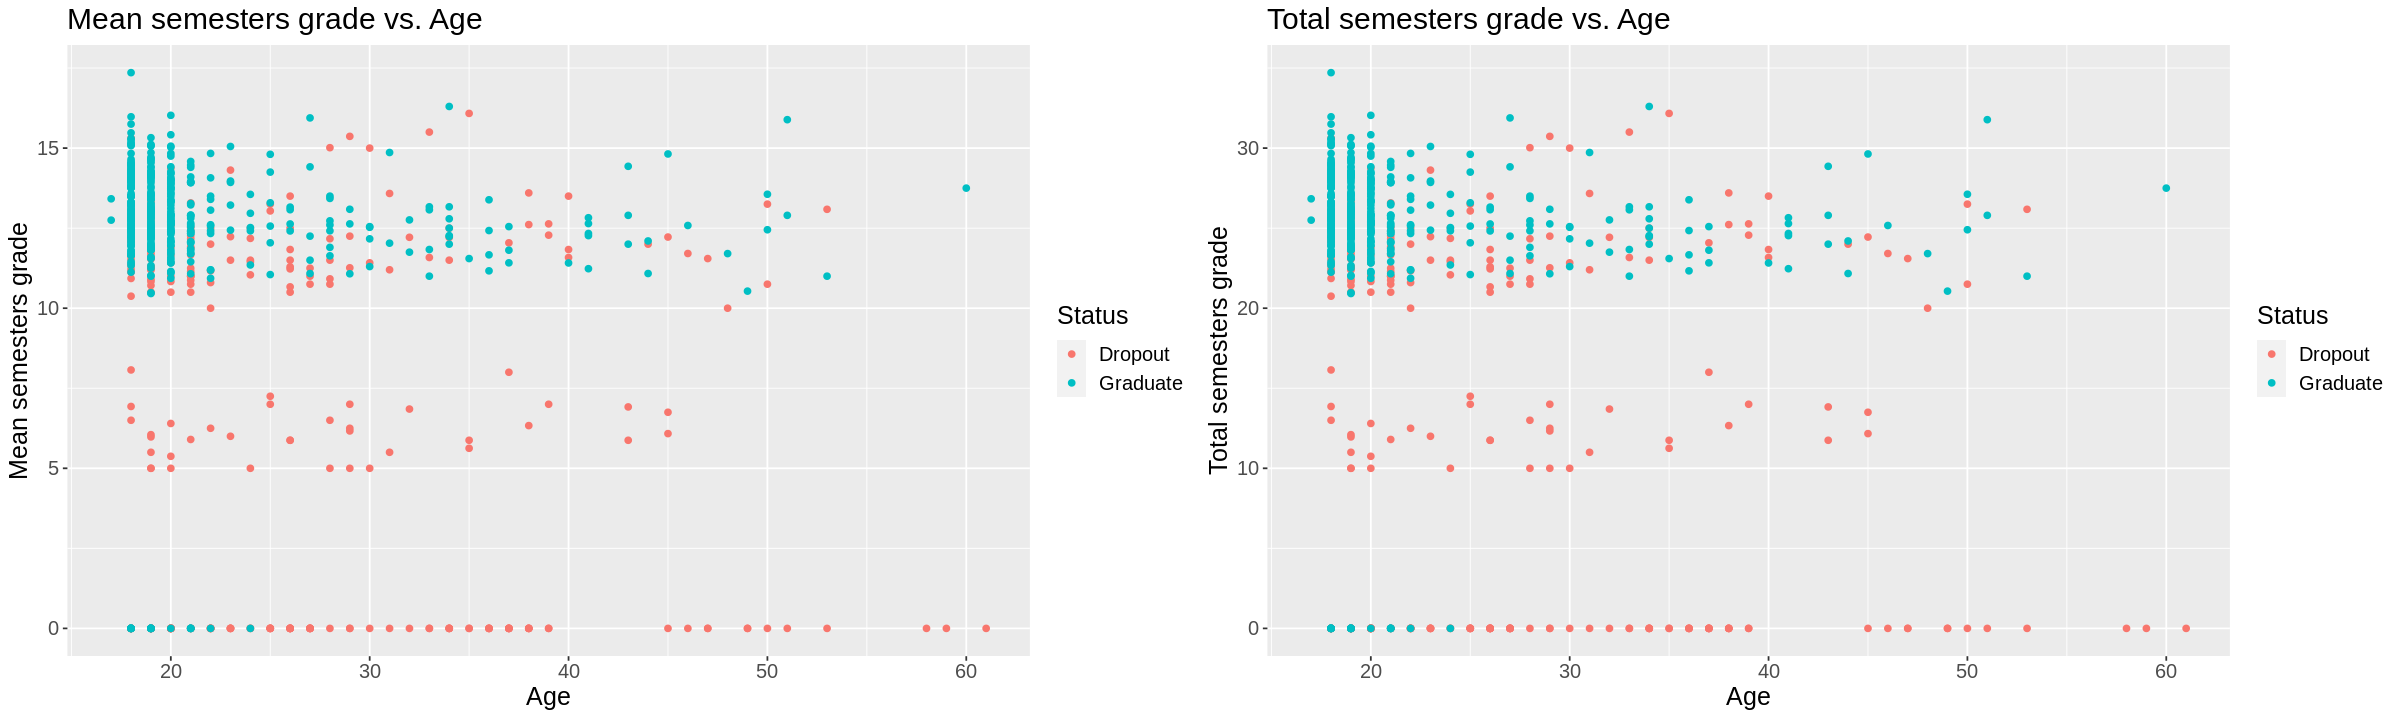

In [8]:
options(repr.plot.width = 20, repr.plot.height = 6)

mean_grade_plot <- data_train |>
    mutate(mean_sem_grade = (first_semester_grade + second_semester_grade) / 2) |>
    ggplot(aes(x = enrollment_age, y = mean_sem_grade, colour = status)) +
    geom_point() +
    labs(x = "Age", y = "Mean semesters grade", title = "Mean semesters grade vs. Age",
         colour = "Status") +
    theme(text = element_text(size = 15))

sum_grade_plot <- data_train |>
    mutate(sum_sem_grade = first_semester_grade + second_semester_grade) |>
    ggplot(aes(x = enrollment_age, y = sum_sem_grade, colour = status)) +
    geom_point() +
    labs(x = "Age", y = "Total semesters grade", title = "Total semesters grade vs. Age",
         colour = "Status") +
    theme(text = element_text(size = 15))

plot_grid(mean_grade_plot, sum_grade_plot)

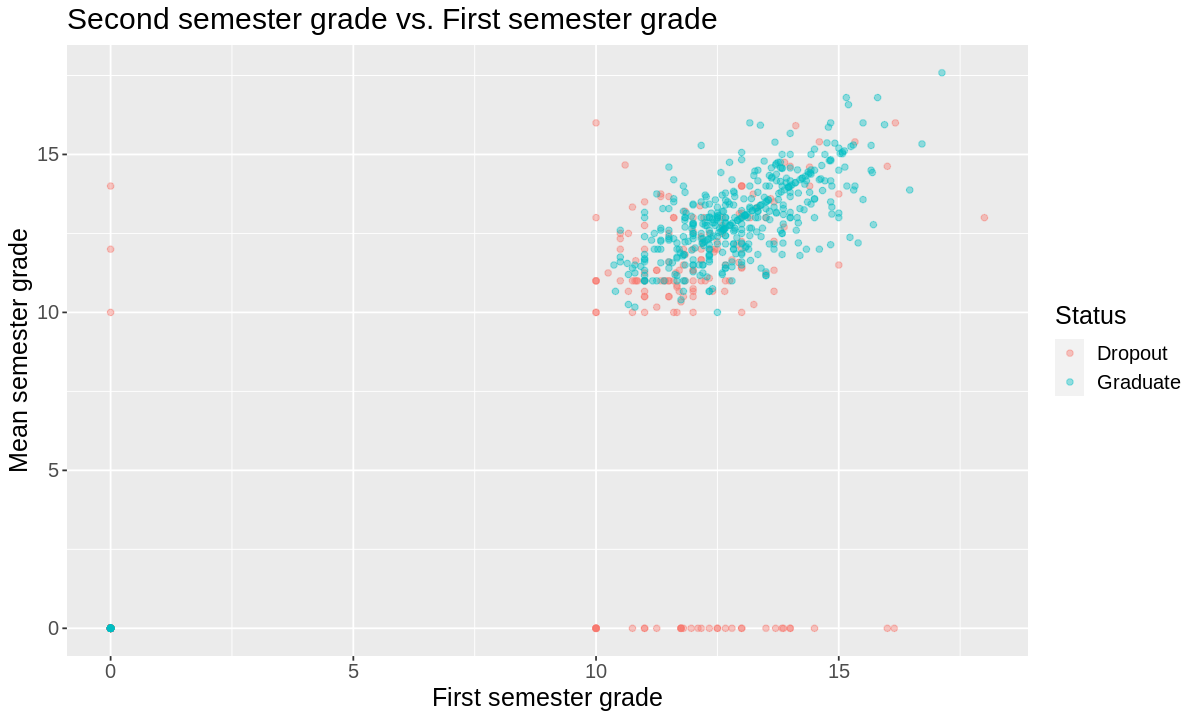

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6)
grade_plot <- ggplot(data_train, 
                     aes(x = first_semester_grade, y = second_semester_grade, colour = status)) +
    geom_point(alpha = 0.4) +
    labs(x = "First semester grade", y = "Mean semester grade", title = "Second semester grade vs. First semester grade",
         colour = "Status") +
    theme(text = element_text(size = 15))
grade_plot